In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as pltclr
import matplotlib.patches as patch
import time
import skimage

import os

from utils.UNeXt import UNet
from utils.data_processing import CellDataset, SubsetSampler

from utils.nb_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
import pprint

In [8]:
np.random.seed(1)
torch.random.manual_seed(1)

modelinfo = torch.load('../tensorboard_logs/220712_1418_0/model.pt',  map_location=torch.device('cpu'));
#modelinfo = torch.load('/home/schmittms/cell_stress/force_prediction_convnext/tensorboard_logs/220713_1538_3/model.pt',  map_location=torch.device('cpu'));

dataset_kwargs = modelinfo['dataset_kwargs']
test_cells = dataset_kwargs['test_cells']

modelinfo['dataset_kwargs']['root'] = '../TractionData_All_16kpa_new/'
modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 960
modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])

dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'exp_schedule': {'type': 'linear', 'width': 311.0, 'e_crit': 30.0}, 'strainenergy_regularization': 0.1, 'reg_schedule': {'type': 'linear', 'width': 311.0, 'e_crit': 30.0}, 'loss_kwargs': {'max_force': 8.0}}


0.05


Text(0, 0.5, 'Difference')

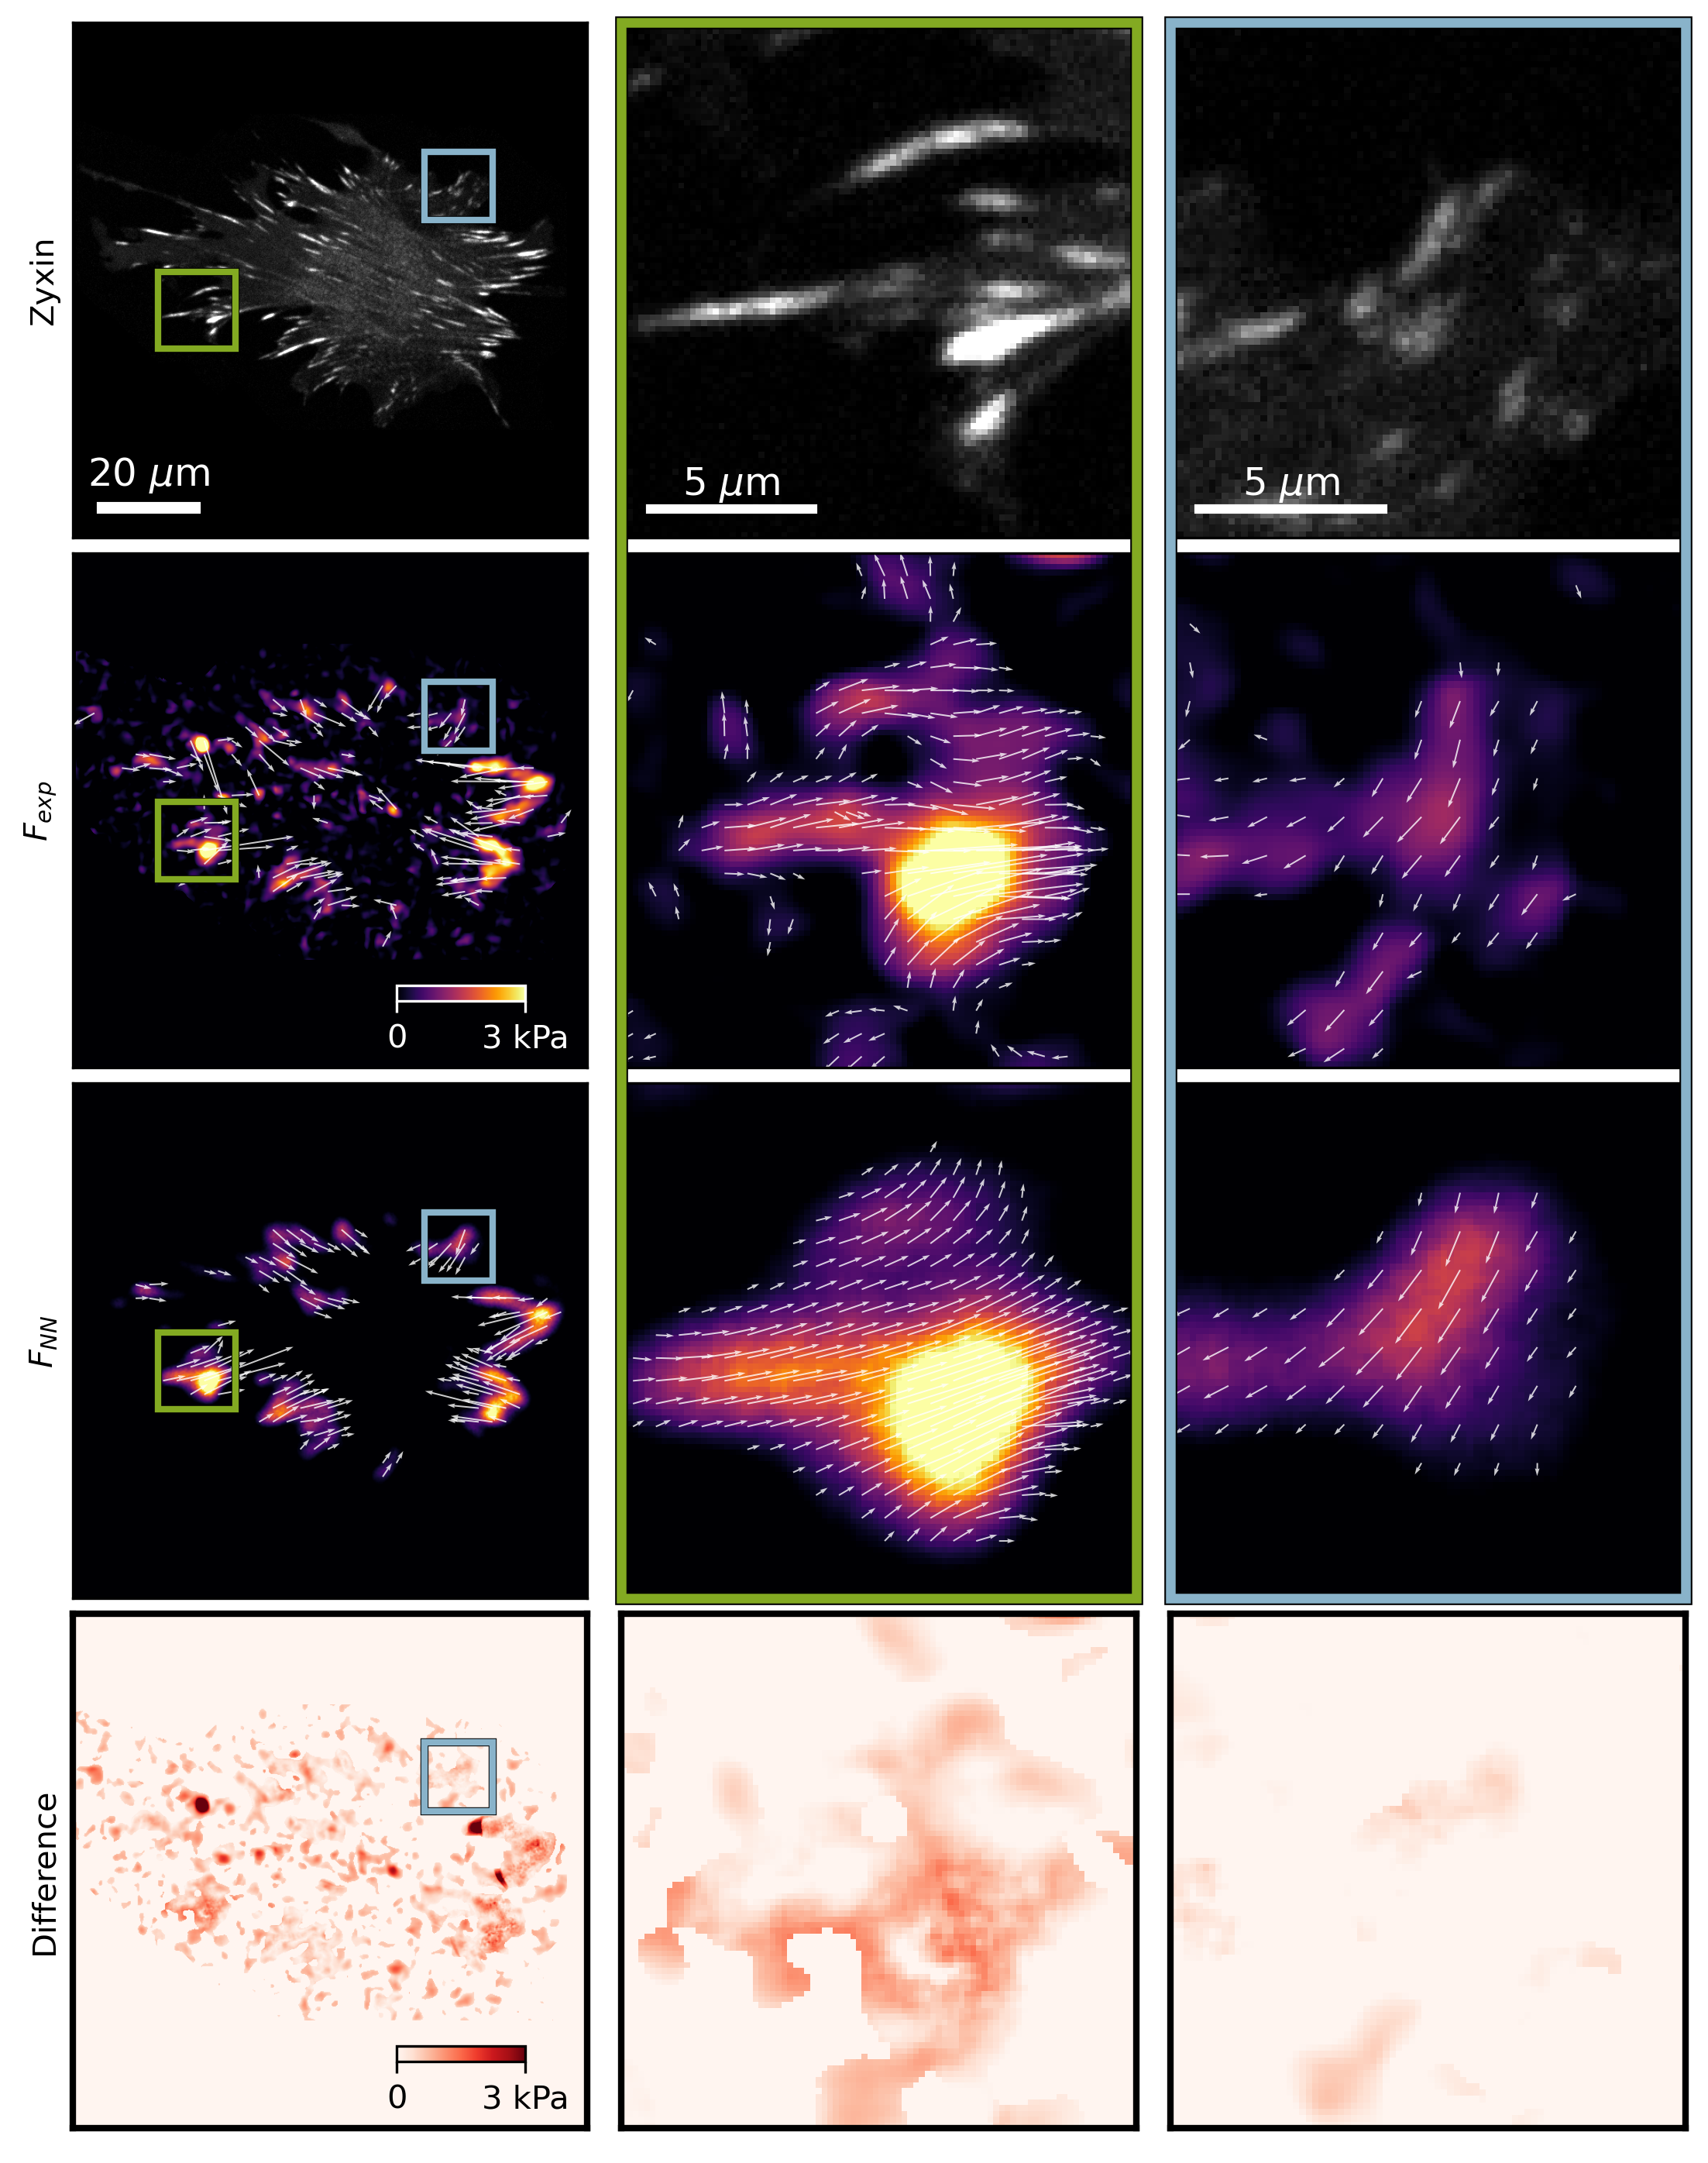

In [19]:
idx = np.sort(dataset.info[dataset.info.folder=='11_cell_4'].index.values)
idx = idx[2]

fig,ax=plt.subplots(4,3,figsize=(3*3,3*4.),dpi=300)

ax = ax.T
fig.subplots_adjust(wspace=0.05, hspace=0.03)

model.eval()
model.to(torch.device('cuda:0'))

sample = dataset[idx]
for k in sample:
    sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

preds = []
for _ in range(5):
    pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
    preds.append(pred)
    
pred = np.mean(preds, axis=0) 
target = sample['output'].detach().cpu().numpy().squeeze() 
zyx = sample['zyxin'].detach().cpu().numpy().squeeze()

fxp, fyp, fxt, fyt = pred[0]*np.cos(pred[1]), pred[0]*np.sin(pred[1]), target[0]*np.cos(target[1]), target[0]*np.sin(target[1])
diff = np.sqrt( (fxp - fxt)**2 + (fyp - fyt)**2 )
diff[target[0]<0.5] = 0
#diff[pred[0]<0.5] = 0

ax[0][0].imshow(zyx/zyx.max(), vmax=0.3, vmin=0., cmap='gray', origin='lower')


vmax = 3
ax[0][1].imshow(target[0], vmax=vmax, vmin=0.4, cmap='inferno', origin='lower')
ax[0][1].quiver( *make_vector_field(*target, 
                                    downsample=16, threshold=0.5 , angmag=True), 
                color='w', scale=20 , width=0.003, alpha=0.8)

ax[0][2].imshow(pred[0], vmax=vmax, vmin=0.4, cmap='inferno', origin='lower')
ax[0][2].quiver( *make_vector_field(*pred,
                                    downsample=16, threshold=0.5 , angmag=True), 
                color='w', scale=20 , width=0.003, alpha=0.8)

ax[0][3].imshow(diff, vmax=vmax, vmin=0., cmap='Reds', origin='lower')

for a in ax[0].flat:
    a.set_xlim(190, 790)
    a.set_ylim(170, 770)
    

### SCALE BAR ###
xlim = ax[0][0].get_xlim()
ylim = ax[0][1].get_ylim()
xd = np.diff(xlim)
yd = np.diff(ylim)
scale_loc = (xlim[0] + xd*0.05, ylim[0] + yd*0.05)
um_per_px = 0.17 #0.17 # N pixels will have real width N*um_per_pix. N um will have size N*(1/um_per_px) pixels
barsize = 20 #um
rect = patch.Rectangle(xy=scale_loc, width=barsize/um_per_px, height=(2*800/960)/um_per_px, color='w')
ax[0][0].text(scale_loc[0] + barsize/(2*um_per_px), (scale_loc[1]+ (2*800/960)/um_per_px)*1.05, f'{barsize} $\\mu$m', color='w', ha='center', va='bottom', fontsize=12)
ax[0][0].add_patch(rect)


ax_hidden = ax[0][-1].inset_axes([0.0, 0.0, 0.0, 0.0])
img = ax_hidden.imshow([[0,vmax]], cmap="inferno", origin='lower')
img.set_visible(False)
ax_hidden.set_visible(False)
cax = ax[0][1].inset_axes([0.63, 0.13, 0.25, 0.03])
cbar = fig.colorbar(img, cax=cax, ticks=[0,3], orientation='horizontal')
cbar.ax.xaxis.set_tick_params(color='w')
cbar.ax.set_xticklabels([0, '3 kPa'])
cbar.outline.set_edgecolor('w')
plt.setp(plt.getp(cax, 'xticklabels'), color='w')
#plt.setp(plt.getp(cax, 'xlabel'), text='F')
plt.setp(plt.getp(cax, 'xlabel'), color='w')


ax_hidden = ax[0][-1].inset_axes([0.0, 0.0, 0.0, 0.0])
img = ax_hidden.imshow([[0,vmax]], cmap="Reds", origin='lower')
img.set_visible(False)
ax_hidden.set_visible(False)
cax = ax[0][-1].inset_axes([0.63, 0.13, 0.25, 0.03])
cbar = fig.colorbar(img, cax=cax, ticks=[0,3], orientation='horizontal')
cbar.ax.set_xticklabels([0, '3 kPa'])



####### BOX 1 ############
box1_w = 90
box1 = [290, 390] # x0, y0, x1, y1
box1 = [*box1, box1[0]+box1_w, box1[1]+box1_w]
box1_color = '#83AA22'
for a in ax[0, :-1]:
    rect = patch.Rectangle(xy=box1[:2], width=box1_w, height=box1_w, color='k', fill=False, linewidth=2.5)
    a.add_patch(rect)
    rect = patch.Rectangle(xy=box1[:2], width=box1_w, height=box1_w, color=box1_color, fill=False, linewidth=2)
    a.add_patch(rect)

ax[1][0].imshow(zyx[box1[1]:box1[3], box1[0]:box1[2]]/zyx.max(), vmax=0.3, vmin=0., cmap='gray', origin='lower')
ax[1][1].imshow(target[0, box1[1]:box1[3], box1[0]:box1[2]], vmax=vmax, vmin=0.4, cmap='inferno', origin='lower')
ax[1][1].quiver( *make_vector_field(*target[:,box1[1]:box1[3], box1[0]:box1[2]], downsample=4, threshold=0.5 , angmag=True), color='w', scale=20, width=0.003, alpha=0.8)
ax[1][2].imshow(pred[0, box1[1]:box1[3], box1[0]:box1[2]], vmax=vmax, vmin=0.4, cmap='inferno', origin='lower')
ax[1][2].quiver( *make_vector_field(*pred[:, box1[1]:box1[3], box1[0]:box1[2]], downsample=4, threshold=0.5 , angmag=True), color='w', scale=20, width=0.003, alpha=0.8)
ax[1][3].imshow(diff[box1[1]:box1[3], box1[0]:box1[2]], vmax=vmax, vmin=0.4, cmap='Reds', origin='lower')


rect = plt.Rectangle((0, -0.5), height=3*(box1_w) + 2*box1_w*fig.subplotpars.hspace, width=1,
                     transform=ax[1][2].get_yaxis_transform(), clip_on=False, 
                     edgecolor='k', fill=False, linewidth=4, zorder=1e3)
ax[1][2].add_patch(rect)

rect = plt.Rectangle((0, -0.5), height=3*(box1_w) + 2*box1_w*fig.subplotpars.hspace, width=1,
                     transform=ax[1][2].get_yaxis_transform(), clip_on=False, 
                     edgecolor=box1_color, fill=False, linewidth=3, zorder=1e3)
ax[1][2].add_patch(rect)


### SCALE BAR ###
xlim = ax[1][0].get_xlim()
ylim = ax[1][1].get_ylim()
xd = np.diff(xlim)
yd = np.diff(ylim)
scale_loc = (xlim[0] + xd*0.05, ylim[0] + yd*0.05)
um_per_px = 0.17 #0.17 # N pixels will have real width N*um_per_pix. N um will have size N*(1/um_per_px) pixels
barsize = 5 #um
rect = patch.Rectangle(xy=scale_loc, width=barsize/um_per_px, height=(2*box1_w/960)/um_per_px, color='w')
ax[1][0].text(scale_loc[0] + barsize/(2*um_per_px), (scale_loc[1]+ (2*box1_w/960)/um_per_px)*1.05, f'{barsize} $\\mu$m', color='w', ha='center', va='bottom', fontsize=12)
ax[1][0].add_patch(rect)




############ BOX 2 ############
box2_color = '#89B3CA'
#box2_w = 110
#box2 = [400, 490] # x0, y0, x1, y1
box2_w = 80
box2 = [600, 540] # x0, y0, x1, y1
box2 = [*box2, box2[0]+box2_w, box2[1]+box2_w]
box2_orig_coords = [box2[0], box2[1] ] # x0, y0, x1, y1
box2_orig_coords = [*box2_orig_coords, box2_orig_coords[0]+box2_w, box2_orig_coords[1]+box2_w]
for a in ax[0]:
    rect = patch.Rectangle(xy=box2[:2], width=box2_w, height=box2_w, color='k', fill=False, linewidth=2.5)
    a.add_patch(rect)
    rect = patch.Rectangle(xy=box2[:2], width=box2_w, height=box2_w, color=box2_color, fill=False, linewidth=2)
    a.add_patch(rect)
    

#vmax = 2
ax[2][0].imshow(zyx[box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]]/zyx.max(), vmax=0.3, vmin=0., cmap='gray', origin='lower')
ax[2][1].imshow(target[0, box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]], vmax=vmax, vmin=0.4 , cmap='inferno', origin='lower')
#normalized_mags_targ = np.asarray([np.ones_like(target[1]), target[1]])
ax[2][1].quiver( *make_vector_field(*target[:,box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]], 
                                    downsample=6, threshold=0.5 , angmag=True), color='w', scale=20 , width=0.003, alpha=0.8)
ax[2][2].imshow(pred[0, box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]], vmax=vmax, vmin=0.4 , cmap='inferno', origin='lower')
normalized_mags_pred = np.asarray([np.ones_like(pred[1]), pred[1]])
ax[2][2].quiver( *make_vector_field(*pred[:, box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]], 
                                    downsample=6, threshold=0.5 , angmag=True), color='w', scale=20 , width=0.003, alpha=0.8)
ax[2][3].imshow(diff[box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]], vmax=vmax, vmin=0.5 , cmap='Reds', origin='lower')

#ax[2][1].imshow(zyx[box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]]/zyx.max() > 0.1, 
#                vmax=0.3, vmin=0., cmap='gray', origin='lower', alpha=0.3)
#ax[2][2].imshow(zyx[box2_orig_coords[1]:box2_orig_coords[3], box2_orig_coords[0]:box2_orig_coords[2]]/zyx.max() > 0.1, 
#                vmax=0.3, vmin=0., cmap='gray', origin='lower', alpha=0.3)

print(fig.subplotpars.wspace)
rect = plt.Rectangle((0,-0.5), height=3*(box2_w) + 2*box2_w*fig.subplotpars.hspace, width=1,
                     transform=ax[2][2].get_yaxis_transform(), clip_on=False, 
                     edgecolor='k', fill=False, linewidth=4, zorder=1e3)
ax[2][2].add_patch(rect)
rect = plt.Rectangle((0,-0.5), height=3*(box2_w) + 2*box2_w*fig.subplotpars.hspace, width=1,
                     transform=ax[2][2].get_yaxis_transform(), clip_on=False, 
                     edgecolor=box2_color, fill=False, linewidth=3, zorder=1e3)
ax[2][2].add_patch(rect)

### SCALE BAR ###
xlim = ax[2][0].get_xlim()
ylim = ax[2][1].get_ylim()
xd = np.diff(xlim)
yd = np.diff(ylim)
scale_loc = (xlim[0] + xd*0.05, ylim[0] + yd*0.05)
um_per_px = 0.17 #0.17 # N pixels will have real width N*um_per_pix. N um will have size N*(1/um_per_px) pixels
barsize = 5 #um
rect = patch.Rectangle(xy=scale_loc, width=barsize/um_per_px, height=(2*box2_w/960)/um_per_px, color='w')
ax[2][0].text(scale_loc[0] + barsize/(2*um_per_px), (scale_loc[1]+ (2*box2_w/960)/um_per_px)*1.05, f'{barsize} $\\mu$m', color='w', ha='center', va='bottom', fontsize=12)
ax[2][0].add_patch(rect)


for a in ax.T[:-1].flat: 
   # a.axis('off')
    a.set_xticks([])
    a.set_yticks([])


for a in ax.T[-1]: 
    a.set_xticks([])
    a.set_yticks([])
    for s in ['top','bottom','left','right']:
        a.spines[s].set_linewidth(2)

ax[0][0].set_ylabel('Zyxin')
ax[0][1].set_ylabel('$F_{exp}$')
ax[0][2].set_ylabel('$F_{NN}$')
ax[0][3].set_ylabel('Difference')


